In [1]:
import scanpy as sc 
import pandas as pd
import SEACells
import numpy as np
import matplotlib
from statistics import mode
import matplotlib.pyplot as plt
from statistics import mode
import sys 
sys.path.insert(0, '../')
import utils
from importlib import reload
reload(utils)
from utils import *
import seaborn as sns
# Some plotting aesthetics
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100


data_path = "/../PrePR-CT/Data/"
save_path_results = "/../PrePR-CT/Results/"

## Import the Data

In [2]:
adata = sc.read(data_path + 'GSE279945_sc_counts_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 298087 × 21265
    obs: 'dose_uM', 'timepoint_hr', 'well', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'sm_name', 'control', 'SMILES', 'sm_lincs_id', 'library_id', 'leiden_res1', 'group', 'cell_type_orig', 'plate_well_celltype_reannotated', 'cell_count_by_well_celltype', 'cell_count_by_plate_well'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'celltypist_celltype_colors', 'donor_id_colors', 'hvg', 'leiden_res1_colors', 'log1p', 'neighbors', 'over_clustering', 'rank_genes_groups'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    obsp: 'connectivities', 'distances'

In [3]:
adata.layers['published_normalized_counts'] = adata.X
adata.layers['raw_counts'] = adata.raw.X
adata.X = adata.layers['raw_counts']
adata.X.A
#del adata.raw

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [4]:
adata.obs.cell_type_orig.unique()

['B cells', 'T cells CD4+', 'Myeloid cells', 'NK cells', 'T regulatory cells', 'T cells CD8+']
Categories (6, object): ['B cells', 'Myeloid cells', 'NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']

In [5]:
len(adata.obs.loc[adata.obs.cell_type_orig == 'B cells'].sm_name.unique())

144

In [6]:
display(adata.obs['dose_uM'].value_counts())
adata.obs.loc[adata.obs['dose_uM'].isin([0.1, 14.1])].control.unique()

dose_uM
1.0     245580
14.1     28452
0.1      24055
Name: count, dtype: int64

array([ True])

## Removing mitochondrial and ribosomal genes

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
adata = adata[:, adata.var[(adata.var.mt == False) & (adata.var.ribo == False)].index.values]
adata 

View of AnnData object with n_obs × n_vars = 298087 × 20842
    obs: 'dose_uM', 'timepoint_hr', 'well', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'sm_name', 'control', 'SMILES', 'sm_lincs_id', 'library_id', 'leiden_res1', 'group', 'cell_type_orig', 'plate_well_celltype_reannotated', 'cell_count_by_well_celltype', 'cell_count_by_plate_well'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'ribo'
    uns: 'cell_type_colors', 'celltypist_celltype_colors', 'donor_id_colors', 'hvg', 'leiden_res1_colors', 'log1p', 'neighbors', 'over_clustering', 'rank_genes_groups'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    layers: 'published_normalized_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [8]:
adata.var.reset_index(inplace = True)
adata.var.rename({"index": "gene_name"}, axis=1, inplace=True)
adata.var.set_index("gene_name", inplace = True)
adata.var

,highly_variable,means,dispersions,dispersions_norm,mt,ribo
gene_name,,,,,,
A1BG,False,0.021539,0.706191,-0.043717,False,False
A1BG-AS1,False,0.046920,0.663751,-0.182112,False,False
A2M,True,0.126748,1.005800,0.933302,False,False
A2M-AS1,True,0.185540,1.232164,1.671470,False,False
A2MP1,True,0.012711,0.979193,0.846538,False,False
...,...,...,...,...,...,...
ZXDC,False,0.088458,0.696352,-0.075800,False,False
ZYG11A,False,0.000616,0.728508,0.029061,False,False
ZYG11B,False,0.178275,0.670788,-0.159163,False,False


## Filtering for cells with a minimum of 1000 counts and genes detected in fewer than 50 cells

In [9]:
# basic qc and pp
adata.layers['counts'] = adata.X.copy()

# remove cells that have less than 1000 counts
sc.pp.filter_cells(adata, min_counts=1000, inplace =True)

# remove genes that are detected in less than 50 cells
sc.pp.filter_genes(adata, min_cells=50, inplace =True)
adata

AnnData object with n_obs × n_vars = 298044 × 20375
    obs: 'dose_uM', 'timepoint_hr', 'well', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'sm_name', 'control', 'SMILES', 'sm_lincs_id', 'library_id', 'leiden_res1', 'group', 'cell_type_orig', 'plate_well_celltype_reannotated', 'cell_count_by_well_celltype', 'cell_count_by_plate_well', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'ribo', 'n_cells'
    uns: 'cell_type_colors', 'celltypist_celltype_colors', 'donor_id_colors', 'hvg', 'leiden_res1_colors', 'log1p', 'neighbors', 'over_clustering', 'rank_genes_groups'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    layers: 'published_normalized_counts', 'raw_counts', 'counts'
    obsp: 'connectivities', 'distances'

In [11]:
adata.obs.rename(columns={"sm_name": "condition", "dose_uM": "dose_value"}, inplace=True)
control_compound = "Dimethyl Sulfoxide"

# Ensure "control" is part of the category list before assignment
if "control" not in adata.obs["condition"].cat.categories:
    adata.obs["condition"] = adata.obs["condition"].cat.add_categories(["control"])

# Now safely assign the new value
adata.obs.loc[adata.obs["condition"] == control_compound, "condition"] = "control"

In [12]:
from sklearn import preprocessing
adata.obs['drug_dose_name'] = adata.obs.condition.astype(str) + '_' + adata.obs.dose_value.astype(str)
adata.obs['cov_drug_dose_name'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.drug_dose_name.astype(str)
adata.obs['cov_drug'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
label_encoder = preprocessing.LabelEncoder()
adata.obs["condition_label"] = label_encoder.fit_transform(adata.obs["condition"])
num_perts = adata.obs["condition_label"].max()+1
print(adata.obs["condition"].unique())
print(adata.obs["condition_label"].unique())

['Belinostat', 'Dabrafenib', 'control', 'Atorvastatin', '5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin..., ..., 'Ceritinib', 'Bosutinib', 'Vandetanib', 'Mometasone Furoate', 'Clotrimazole']
Length: 144
Categories (145, object): ['5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin..., 'ABT737', 'ABT-199 (GDC-0199)', 'AMD-070 (hydrochloride)', ..., 'Vardenafil', 'Vorinostat', 'YK 4-279', 'control']
[ 24  42 143  14   0 134  19   3   5  47  59  87  17 114 122  92  43  11
  37 103  97  99  51  96  21  95 123  62  70  49  35 137  63 104 133  53
  22   6 120 109  13 108 130  58 100  84  16  71  68  90 125  30  20 126
  80  73  12  64  78  69  65 102  94 140  48  33  75  76 110 141 136  44
  52  66 113  15 124  29  36  67 131 106  31 128  98 117 142 116  23  54
  46  86   2  85  26  40  50  83  18   4  93 118  81  91 139   9  88   7
 127  28 132  10 115  60  55   8  77  57 135 101  61  45  27 119  79  56
 105  39 129  72 111 107 112  89   1 121  32  41  74  34  25 138  82  38]


## Normalizing the count matrix & Selecting 5000 HVGs.

In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

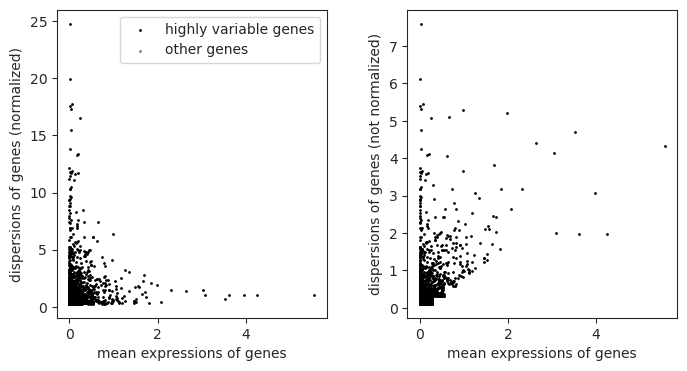

In [14]:
sc.pp.highly_variable_genes(adata, subset=True, n_top_genes = 5000)
sc.pl.highly_variable_genes(adata)

## UMAP Plot of cell types

In [15]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

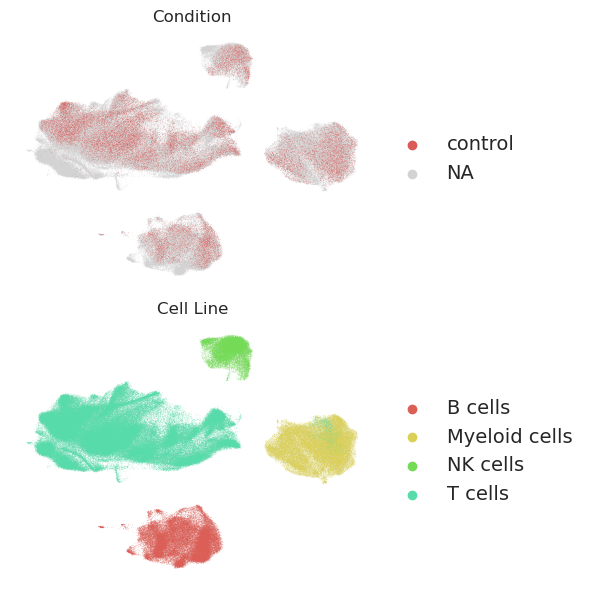

In [16]:
fig, axes = plt.subplots(nrows=2, figsize=(6, 6))  # Adjust figsize as needed
# Plot UMAP 1 in the first subplot if it's not empty
sc.pl.umap(adata=adata, color=["condition"], groups = ["control"], legend_fontsize=14,ax = axes[0],
           title = "Condition",
           show=False, palette = sns.color_palette("hls", num_perts),
           frameon=False)

sc.pl.umap(adata=adata, color=["cell_type"],legend_fontsize=14,ax = axes[1],
           title = "Cell Line",
           show=False, palette = sns.color_palette("hls", 7),
           frameon=False)

# Adjust spacing between subplots
plt.tight_layout()

# Show the merged plot
plt.savefig(save_path_results+'UMAP_NeurIPS.pdf', bbox_inches='tight')
plt.show()

## Constructing cell type graphs over control cells 

In [17]:
ctrl_data = adata[adata.obs.condition == 'control'].copy()
ctrl_data

AnnData object with n_obs × n_vars = 28452 × 5000
    obs: 'dose_value', 'timepoint_hr', 'well', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'condition', 'control', 'SMILES', 'sm_lincs_id', 'library_id', 'leiden_res1', 'group', 'cell_type_orig', 'plate_well_celltype_reannotated', 'cell_count_by_well_celltype', 'cell_count_by_plate_well', 'n_counts', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'condition_label'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'ribo', 'n_cells'
    uns: 'cell_type_colors', 'celltypist_celltype_colors', 'donor_id_colors', 'hvg', 'leiden_res1_colors', 'log1p', 'neighbors', 'over_clustering', 'rank_genes_groups', 'pca', 'umap', 'condition_colors'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    varm: 'PCs'
    layers: 'published_normalized_counts', 'raw_counts', 'counts'
    obsp: 'connectivities', 'distances'

In [18]:
n_SEACells = int(len(ctrl_data) / 75)
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
n_SEACells

379

In [19]:
model = SEACells.core.SEACells(ctrl_data, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [20]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/28452 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/28452 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/28452 [00:00<?, ?it/s]

Constructing CSR matrix...


In [21]:
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 355 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 34/34 [00:01<00:00, 20.26it/s]

Selecting 24 cells from greedy initialization.


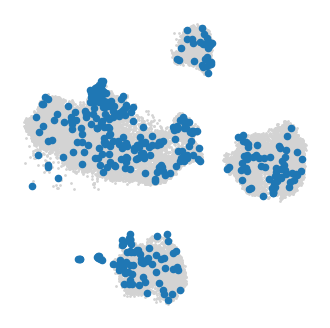

In [22]:
SEACells.plot.plot_initialization(ctrl_data, model)

In [23]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00311
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 26 iterations.


In [24]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 27 iterations
Ran for 32 iterations


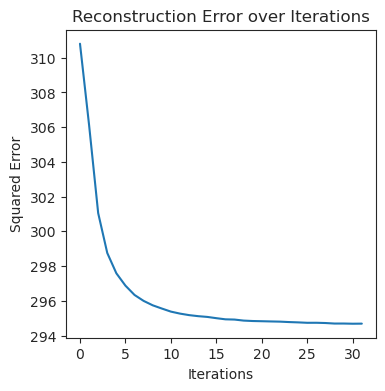

In [25]:
model.plot_convergence()

In [26]:
adata.obs['SEACell'] = 'None'
adata.obs.loc[ctrl_data.obs.index.tolist(), 'SEACell'] = ctrl_data.obs['SEACell'].values

In [27]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ctrl_data,  model.A_, 
                                                          celltype_label='cell_type', summarize_layer = 'counts', minimum_weight = 0.05)
SEACell_soft_ad.X.A

100%|██████████| 379/379 [05:57<00:00,  1.06it/s]


array([[0.00237316, 0.01867839, 0.00171644, ..., 0.21478414, 0.09727464,
        0.03901574],
       [0.52900684, 0.07758903, 0.        , ..., 0.70768178, 0.05145596,
        0.11181139],
       [0.        , 0.00249285, 0.        , ..., 0.25562621, 0.04420283,
        0.06605432],
       ...,
       [0.00209345, 0.020788  , 0.00095436, ..., 0.19204857, 0.10860835,
        0.05225633],
       [0.02638017, 0.05438735, 0.        , ..., 0.27675909, 0.07535859,
        0.05294023],
       [0.34211941, 0.10514324, 0.        , ..., 0.54447286, 0.02560146,
        0.0891926 ]])

In [28]:
SEACell_soft_ad.obs
SEACell_soft_ad.obs.rename({"celltype": "cell_type"}, axis=1, inplace=True)
SEACell_soft_ad.obs.cell_type.value_counts()

cell_type
T cells          212
Myeloid cells     73
B cells           66
NK cells          28
Name: count, dtype: int64

In [29]:
SEACell_soft_ad.write(data_path+'SEACell_soft_ad_Neurips.h5ad')

In [30]:
SEACell_soft_ad = sc.read(data_path+'SEACell_soft_ad_Neurips.h5ad')
SEACell_soft_ad

AnnData object with n_obs × n_vars = 379 × 5000
    obs: 'Pseudo-sizes', 'cell_type', 'celltype_purity'

In [31]:
import os
import networkx as nx
from torch_geometric.utils.convert import from_networkx
from sklearn.metrics import mean_squared_error
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip, HeteroData, Batch
from torch_geometric.utils import *
import torch
from torch import nn
cell_type_network = {}
# Leaf directory 
directory = "NeurIPS"
# Parent Directories 
parent_dir = "/../PrePR-CT/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in SEACell_soft_ad.obs.cell_type.unique():
    print(cell_type)
    cell = Correlation_matrix(SEACell_soft_ad, cell_type, 'cell_type',
                       hv_genes_cells = None, union_HVGs = True)
    threshold = np.percentile(np.abs(cell[0].values), 99.0)
    print("threshold:", threshold)
    g = create_coexpression_graph(SEACell_soft_ad, cell, cell_type, threshold, 'gene_name')
    if g.num_nodes >= max_nodes:
        max_nodes = g.num_nodes
    cell_type_network[cell_type] = g
    genes_pos.append(cell_type_network[cell_type].pos)
    cell_type_network[cell_type].pos = torch.tensor(cell_type_network[cell_type].pos)
    torch.save(cell_type_network[cell_type] , os.path.join(path,cell_type+'_coexpr_graph.pkl'))

cell_type_network

/ibex/scratch/alsulara/PrePR-CT/graphs/NeurIPS
File exists!
T cells


/home/alsulara/miniconda3/envs/PrePR-CT/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/PrePR-CT/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.6245951304133606
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250001
number_of_edges after removing self loops:  245066
final number_of_edges:  245066
Myeloid cells


/home/alsulara/miniconda3/envs/PrePR-CT/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/PrePR-CT/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.5131705496349035
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250000
number_of_edges after removing self loops:  245214
final number_of_edges:  245214
B cells


/home/alsulara/miniconda3/envs/PrePR-CT/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/PrePR-CT/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.7477837878649678
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250001
number_of_edges after removing self loops:  245246
final number_of_edges:  245246
NK cells


/home/alsulara/miniconda3/envs/PrePR-CT/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/PrePR-CT/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.7722197719228808
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250000
number_of_edges after removing self loops:  245562
final number_of_edges:  245562


{'T cells': Data(x=[2342, 212], edge_index=[2, 245066], edge_attr=[245066], pos=[2342]),
 'Myeloid cells': Data(x=[4198, 73], edge_index=[2, 245214], edge_attr=[245214], pos=[4198]),
 'B cells': Data(x=[2832, 66], edge_index=[2, 245246], edge_attr=[245246], pos=[2832]),
 'NK cells': Data(x=[2692, 28], edge_index=[2, 245562], edge_attr=[245562], pos=[2692])}

In [33]:
overlap_df = pd.DataFrame(index = cell_type_network.keys(), columns = cell_type_network.keys())
for key1 in cell_type_network.keys():
    for key2 in cell_type_network.keys():
        overlap_df.loc[key1, key2] = (len(np.intersect1d(cell_type_network[key1].pos, cell_type_network[key2].pos)))

# identify the furthest cell type
indices = np.argsort(overlap_df.values, axis=0)[-4, :]
print(indices)
testing_cell = overlap_df.columns[mode(indices)]
print(testing_cell)
overlap_df

[3 0 0 0]
T cells


,T cells,Myeloid cells,B cells,NK cells
T cells,2342,2171,1701,1568
Myeloid cells,2171,4198,2534,2385
B cells,1701,2534,2832,1727
NK cells,1568,2385,1727,2692


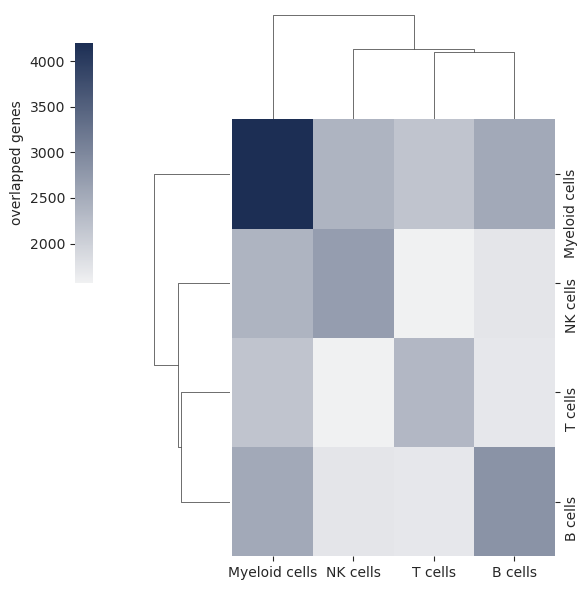

In [34]:
# sns.set()
cmap = sns.light_palette("#1C2E54", as_cmap=True, n_colors = 5)
sns.set_style( {'axes.grid' : False})
g = sns.clustermap(overlap_df.astype(int), figsize=(6, 6), cmap = cmap
                   , cbar_kws={'label': 'overlapped genes', 'location': 'left'})
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((-0.1, .52, .03, .4))
plt.savefig(save_path_results+'overlap_matrix_neurips.pdf', bbox_inches='tight')
plt.show()
sns.set()

In [2]:
adata.write(data_path+'Neurips_Data_Processed.h5ad')
adata

In [3]:
adata = sc.read(data_path+'Neurips_Data_Processed.h5ad')
adata

AnnData object with n_obs × n_vars = 291793 × 5000
    obs: 'dose_value', 'timepoint_hr', 'well', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'condition', 'control', 'SMILES', 'sm_lincs_id', 'library_id', 'leiden_res1', 'group', 'cell_type_orig', 'plate_well_celltype_reannotated', 'cell_count_by_well_celltype', 'cell_count_by_plate_well', 'n_counts', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'condition_label', 'SEACell'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'ribo', 'n_cells'
    uns: 'cell_type_colors', 'celltypist_celltype_colors', 'condition_colors', 'donor_id_colors', 'hvg', 'leiden_res1_colors', 'log1p', 'neighbors', 'over_clustering', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    varm: 'PCs'
    layers: 'counts', 'published_normalized_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [4]:
print(len(adata.obs.loc[adata.obs.condition == 'control']), len(adata.obs.loc[adata.obs.condition != 'control']))
print(len(adata.obs.loc[adata.obs.condition == 'control']) + len(adata.obs.loc[adata.obs.condition != 'control']))

28452 263341
291793


In [12]:
cross_tab = pd.crosstab(adata.obs['cell_type'], adata.obs['condition'])
cross_tab

condition,ABT-199 (GDC-0199),AMD-070 (hydrochloride),AT 7867,AVL-292,AZ628,AZD3514,AZD4547,AZD-8330,Alogliptin,Amiodarone,...,Tivozanib,Topotecan,Tosedostat,Trametinib,Vandetanib,Vanoxerine,Vardenafil,Vorinostat,YK 4-279,control
cell_type,,,,,,,,,,,,,,,,,,,,,
B cells,30,219,348,283,228,244,281,308,226,255,...,231,314,219,309,219,244,245,227,270,4396
Myeloid cells,402,242,367,133,77,229,234,109,259,256,...,290,324,240,146,229,288,266,108,327,5235
NK cells,115,116,151,131,109,105,92,127,122,112,...,123,130,87,116,123,116,98,95,132,1957
T cells,817,914,1126,1153,965,949,926,960,959,998,...,1154,1227,843,1071,949,891,946,1087,934,16864


In [13]:
import os
cell_type_network = {}
# Leaf directory 
directory = "NeurIPS"
# Parent Directories 
parent_dir = "/../PrePR-CT/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in adata.obs.cell_type.unique():
    print(cell_type)
    cell_type_network[cell_type] = torch.load(os.path.join(path,cell_type+'_coexpr_graph.pkl'))
    if cell_type_network[cell_type].num_nodes >= max_nodes:
        max_nodes = cell_type_network[cell_type].num_nodes
print(max_nodes)
cell_type_network 

/ibex/scratch/alsulara/PrePR-CT/graphs/NeurIPS
File exists!
B cells
T cells
Myeloid cells
NK cells
4198


{'B cells': Data(x=[2832, 66], edge_index=[2, 245246], edge_attr=[245246], pos=[2832]),
 'T cells': Data(x=[2342, 212], edge_index=[2, 245066], edge_attr=[245066], pos=[2342]),
 'Myeloid cells': Data(x=[4198, 73], edge_index=[2, 245214], edge_attr=[245214], pos=[4198]),
 'NK cells': Data(x=[2692, 28], edge_index=[2, 245562], edge_attr=[245562], pos=[2692])}

In [14]:
# Compute the crosstab
crosstab_result = pd.crosstab(adata.obs['cell_type'], adata.obs['condition'])

# Identify drugs (conditions) that appear in at least one cell type with fewer than 30 samples
drugs_to_remove = crosstab_result.columns[crosstab_result.lt(30).any()]

# Filter out those drugs from the dataset
adata = adata[~adata.obs['condition'].isin(drugs_to_remove)]

In [16]:
from scperturb import *
estats = edist_to_control(adata, obs_key='condition', obsm_key='X_pca', dist='sqeuclidean')
# Sort the Series in ascending order:
if 'control' in estats.index:
    control_values = estats.drop('control')
sorted_control = control_values.sort_values(by = 'distance' , ascending=True)

# The 7 drugs with the smallest values are the closest to control
closest_drugs = sorted_control.head(3).index.tolist()

# The 7 drugs with the highest values are the farthest from control
farthest_drugs = sorted_control.tail(3).index.tolist()

# Combine them into a single list if desired
testing_drugs = closest_drugs + farthest_drugs

print("Closest drugs:", closest_drugs)
print("Farthest drugs:", farthest_drugs)
print("Testing drugs:", testing_drugs)

100%|██████████| 136/136 [01:37<00:00,  1.39it/s]


Closest drugs: ['Penfluridol', 'Flutamide', 'SCH-58261']
Farthest drugs: ['Scriptaid', 'Ketoconazole', 'Dactolisib']
Testing drugs: ['Penfluridol', 'Flutamide', 'SCH-58261', 'Scriptaid', 'Ketoconazole', 'Dactolisib']


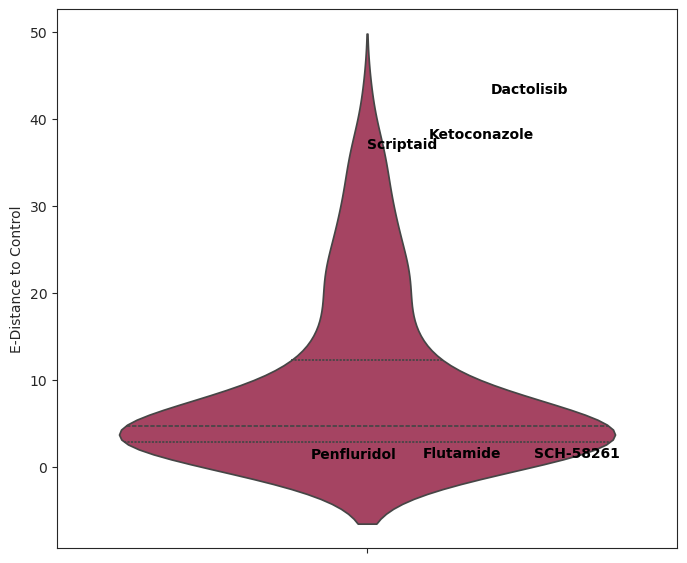

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_distance_violin(sorted_control, num_selected=3, text_offset=0.1):
    """
    Plots the distance distribution of drugs from the control group as a violin plot,
    highlighting the top `num_selected` closest and farthest drugs while avoiding text overlap.

    Parameters:
    - sorted_control: Pandas DataFrame with 'distance' column (sorted in ascending order)
    - num_selected: Number of closest and farthest drugs to highlight
    - text_offset: Vertical offset to prevent text overlap
    """

    # Extract distances
    distances = sorted_control['distance'].values

    # Extract selected drug names and distances
    closest_drugs = sorted_control.index[:num_selected].tolist()
    farthest_drugs = sorted_control.index[-num_selected:].tolist()
    closest_distances = sorted_control['distance'][:num_selected].tolist()
    farthest_distances = sorted_control['distance'][-num_selected:].tolist()

    # Plot violin plot
    plt.figure(figsize=(8, 7))
    sns.violinplot(y=distances, color='#B5345C', inner="quartile")

    # Annotate closest drugs (adjusting y position to avoid overlap)
    for i, (drug, dist) in enumerate(zip(closest_drugs, closest_distances)):
        plt.text(x = (i-0.5) * (text_offset + 0.08), y=dist , s=drug, color="black", fontsize=10, fontweight="bold", verticalalignment='bottom')

    # Annotate farthest drugs (adjusting y position to avoid overlap)
    for i, (drug, dist) in enumerate(zip(farthest_drugs, farthest_distances)):
        plt.text(x = i * text_offset, y=dist, s=drug, color="black", fontsize=10, fontweight="bold", verticalalignment='bottom')

    # Labels and title
    plt.ylabel("E-Distance to Control")
    # Show plot
    plt.savefig('distance_dist.pdf', bbox_inches="tight", dpi=300)
    plt.show()

# Example usage (assuming `sorted_control` is a DataFrame with a 'distance' column sorted in ascending order)
plot_distance_violin(sorted_control)


In [8]:
stim_data = adata[adata.obs.condition != 'control'].copy()
stim_data.layers['ctrl_x'] = stim_data.X.A
ctrl_data = adata[adata.obs.condition == 'control'].copy()

for cell_type in adata.obs.cell_type.unique():
    genes = cell_type_network[cell_type].pos.tolist()
    cell_type_network[cell_type].x = torch.mean(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    std = torch.var(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    cell_type_network[cell_type].x = torch.cat([cell_type_network[cell_type].x.unsqueeze(1), std.unsqueeze(1)], dim = 1)    


for cov_drug in tq.tqdm(stim_data.obs.cov_drug.unique()):
    cell_type = cov_drug.split('_')[0]
    ad_ctrl = ctrl_data[ctrl_data.obs.cell_type == cell_type].copy()
    ad_stim = stim_data[stim_data.obs.cov_drug == cov_drug].copy()
    num_samples = len(ad_stim)
    sele_samples = balance_subsample(np.array(ad_ctrl.obs.index.values.tolist()), np.array(ad_ctrl.obs.SEACell.values.tolist()), num_samples)
    stim_data[ ad_stim.obs.index.values,: ].layers['ctrl_x'] = ad_ctrl[sele_samples, :].copy().X.A

  0%|          | 0/540 [00:00<?, ?it/s]

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem, DataStructs
from tqdm import tqdm

import pandas as pd

# Define the file path
file_path = data_path + "SMILES_feat_all_datasets.csv"

# Read the Parquet file into a DataFrames
df = pd.read_csv(file_path)

# Define a list of drugs and their corresponding SMILES strings
canonical_smiles = {}
drug_smiles = adata.obs[['condition', 'SMILES']]
drug_smiles = drug_smiles.drop_duplicates()
drug_smiles = dict(zip(drug_smiles['condition'], drug_smiles['SMILES']))
canonical_smiles = {
    drug_name: candidate 
    for drug_name, smile in drug_smiles.items() if drug_name != 'control'
    for candidate in [list(list(df.loc[df['SMILES'] == smile].values)[0])[1:]]
    if candidate  # Only include if candidate is non-empty
}

In [57]:
from importlib import reload
import utils
reload(utils)
from utils import *
cells_train = create_cells(stim_data, cell_type_network, canonical_smiles)


['B cells', 'T cells', 'Myeloid cells', 'NK cells']
Categories (4, object): ['B cells', 'Myeloid cells', 'NK cells', 'T cells'] ['Belinostat', 'Dabrafenib', 'Atorvastatin', 'Topotecan', 'BMS-265246', ..., 'Ceritinib', 'Bosutinib', 'Vandetanib', 'Mometasone Furoate', 'Clotrimazole']
Length: 135
Categories (135, object): ['ABT-199 (GDC-0199)', 'AMD-070 (hydrochloride)', 'AT 7867', 'AVL-292', ..., 'Vanoxerine', 'Vardenafil', 'Vorinostat', 'YK 4-279']


Processing cov_drugs:   0%|          | 0/540 [00:00<?, ?it/s]

Processing B cells_Belinostat samples:   0%|          | 0/4165 [00:00<?, ?it/s]

Processing T cells_Belinostat samples:   0%|          | 0/15864 [00:00<?, ?it/s]

Processing Myeloid cells_Belinostat samples:   0%|          | 0/2502 [00:00<?, ?it/s]

Processing NK cells_Belinostat samples:   0%|          | 0/1523 [00:00<?, ?it/s]

Processing T cells_Dabrafenib samples:   0%|          | 0/14766 [00:00<?, ?it/s]

Processing Myeloid cells_Dabrafenib samples:   0%|          | 0/6005 [00:00<?, ?it/s]

Processing B cells_Dabrafenib samples:   0%|          | 0/3936 [00:00<?, ?it/s]

Processing NK cells_Dabrafenib samples:   0%|          | 0/1626 [00:00<?, ?it/s]

Processing Myeloid cells_Atorvastatin samples:   0%|          | 0/258 [00:00<?, ?it/s]

Processing T cells_Atorvastatin samples:   0%|          | 0/1091 [00:00<?, ?it/s]

Processing B cells_Atorvastatin samples:   0%|          | 0/267 [00:00<?, ?it/s]

Processing NK cells_Atorvastatin samples:   0%|          | 0/122 [00:00<?, ?it/s]

Processing T cells_Topotecan samples:   0%|          | 0/1227 [00:00<?, ?it/s]

Processing NK cells_Topotecan samples:   0%|          | 0/130 [00:00<?, ?it/s]

Processing B cells_Topotecan samples:   0%|          | 0/314 [00:00<?, ?it/s]

Processing Myeloid cells_Topotecan samples:   0%|          | 0/324 [00:00<?, ?it/s]

Processing T cells_BMS-265246 samples:   0%|          | 0/1339 [00:00<?, ?it/s]

Processing B cells_BMS-265246 samples:   0%|          | 0/409 [00:00<?, ?it/s]

Processing NK cells_BMS-265246 samples:   0%|          | 0/129 [00:00<?, ?it/s]

Processing Myeloid cells_BMS-265246 samples:   0%|          | 0/432 [00:00<?, ?it/s]

Processing B cells_AMD-070 (hydrochloride) samples:   0%|          | 0/219 [00:00<?, ?it/s]

Processing T cells_AMD-070 (hydrochloride) samples:   0%|          | 0/914 [00:00<?, ?it/s]

Processing Myeloid cells_AMD-070 (hydrochloride) samples:   0%|          | 0/242 [00:00<?, ?it/s]

Processing NK cells_AMD-070 (hydrochloride) samples:   0%|          | 0/116 [00:00<?, ?it/s]

Processing T cells_Desloratadine samples:   0%|          | 0/997 [00:00<?, ?it/s]

Processing B cells_Desloratadine samples:   0%|          | 0/258 [00:00<?, ?it/s]

Processing Myeloid cells_Desloratadine samples:   0%|          | 0/295 [00:00<?, ?it/s]

Processing NK cells_Desloratadine samples:   0%|          | 0/111 [00:00<?, ?it/s]

Processing Myeloid cells_O-Demethylated Adapalene samples:   0%|          | 0/201 [00:00<?, ?it/s]

Processing NK cells_O-Demethylated Adapalene samples:   0%|          | 0/105 [00:00<?, ?it/s]

Processing T cells_O-Demethylated Adapalene samples:   0%|          | 0/916 [00:00<?, ?it/s]

Processing B cells_O-Demethylated Adapalene samples:   0%|          | 0/255 [00:00<?, ?it/s]

Processing T cells_BAY 87-2243 samples:   0%|          | 0/1102 [00:00<?, ?it/s]

Processing Myeloid cells_BAY 87-2243 samples:   0%|          | 0/242 [00:00<?, ?it/s]

Processing B cells_BAY 87-2243 samples:   0%|          | 0/260 [00:00<?, ?it/s]

Processing NK cells_BAY 87-2243 samples:   0%|          | 0/114 [00:00<?, ?it/s]

Processing NK cells_Ruxolitinib samples:   0%|          | 0/109 [00:00<?, ?it/s]

Processing T cells_Ruxolitinib samples:   0%|          | 0/938 [00:00<?, ?it/s]

Processing B cells_Ruxolitinib samples:   0%|          | 0/205 [00:00<?, ?it/s]

Processing Myeloid cells_Ruxolitinib samples:   0%|          | 0/94 [00:00<?, ?it/s]

Processing T cells_Sgc-cbp30 samples:   0%|          | 0/969 [00:00<?, ?it/s]

Processing NK cells_Sgc-cbp30 samples:   0%|          | 0/120 [00:00<?, ?it/s]

Processing B cells_Sgc-cbp30 samples:   0%|          | 0/267 [00:00<?, ?it/s]

Processing Myeloid cells_Sgc-cbp30 samples:   0%|          | 0/306 [00:00<?, ?it/s]

Processing T cells_PF-04691502 samples:   0%|          | 0/747 [00:00<?, ?it/s]

Processing B cells_PF-04691502 samples:   0%|          | 0/177 [00:00<?, ?it/s]

Processing NK cells_PF-04691502 samples:   0%|          | 0/76 [00:00<?, ?it/s]

Processing Myeloid cells_PF-04691502 samples:   0%|          | 0/46 [00:00<?, ?it/s]

Processing T cells_Dactolisib samples:   0%|          | 0/1056 [00:00<?, ?it/s]

Processing B cells_Dactolisib samples:   0%|          | 0/209 [00:00<?, ?it/s]

Processing NK cells_Dactolisib samples:   0%|          | 0/115 [00:00<?, ?it/s]

Processing Myeloid cells_Dactolisib samples:   0%|          | 0/87 [00:00<?, ?it/s]

Processing T cells_Alogliptin samples:   0%|          | 0/959 [00:00<?, ?it/s]

Processing Myeloid cells_Alogliptin samples:   0%|          | 0/259 [00:00<?, ?it/s]

Processing B cells_Alogliptin samples:   0%|          | 0/226 [00:00<?, ?it/s]

Processing NK cells_Alogliptin samples:   0%|          | 0/122 [00:00<?, ?it/s]

Processing T cells_Clomipramine samples:   0%|          | 0/1047 [00:00<?, ?it/s]

Processing B cells_Clomipramine samples:   0%|          | 0/236 [00:00<?, ?it/s]

Processing Myeloid cells_Clomipramine samples:   0%|          | 0/297 [00:00<?, ?it/s]

Processing NK cells_Clomipramine samples:   0%|          | 0/137 [00:00<?, ?it/s]

Processing T cells_Protriptyline samples:   0%|          | 0/1046 [00:00<?, ?it/s]

Processing Myeloid cells_Protriptyline samples:   0%|          | 0/268 [00:00<?, ?it/s]

Processing B cells_Protriptyline samples:   0%|          | 0/220 [00:00<?, ?it/s]

Processing NK cells_Protriptyline samples:   0%|          | 0/124 [00:00<?, ?it/s]

Processing T cells_Phenylbutazone samples:   0%|          | 0/1220 [00:00<?, ?it/s]

Processing B cells_Phenylbutazone samples:   0%|          | 0/313 [00:00<?, ?it/s]

Processing Myeloid cells_Phenylbutazone samples:   0%|          | 0/321 [00:00<?, ?it/s]

Processing NK cells_Phenylbutazone samples:   0%|          | 0/128 [00:00<?, ?it/s]

Processing T cells_Pomalidomide samples:   0%|          | 0/1183 [00:00<?, ?it/s]

Processing Myeloid cells_Pomalidomide samples:   0%|          | 0/340 [00:00<?, ?it/s]

Processing NK cells_Pomalidomide samples:   0%|          | 0/135 [00:00<?, ?it/s]

Processing B cells_Pomalidomide samples:   0%|          | 0/291 [00:00<?, ?it/s]

Processing T cells_FK 866 samples:   0%|          | 0/800 [00:00<?, ?it/s]

Processing Myeloid cells_FK 866 samples:   0%|          | 0/195 [00:00<?, ?it/s]

Processing B cells_FK 866 samples:   0%|          | 0/228 [00:00<?, ?it/s]

Processing NK cells_FK 866 samples:   0%|          | 0/100 [00:00<?, ?it/s]

Processing T cells_Perhexiline samples:   0%|          | 0/915 [00:00<?, ?it/s]

Processing B cells_Perhexiline samples:   0%|          | 0/226 [00:00<?, ?it/s]

Processing Myeloid cells_Perhexiline samples:   0%|          | 0/60 [00:00<?, ?it/s]

Processing NK cells_Perhexiline samples:   0%|          | 0/78 [00:00<?, ?it/s]

Processing NK cells_BMS-536924 samples:   0%|          | 0/119 [00:00<?, ?it/s]

Processing T cells_BMS-536924 samples:   0%|          | 0/885 [00:00<?, ?it/s]

Processing B cells_BMS-536924 samples:   0%|          | 0/201 [00:00<?, ?it/s]

Processing Myeloid cells_BMS-536924 samples:   0%|          | 0/53 [00:00<?, ?it/s]

Processing T cells_Penfluridol samples:   0%|          | 0/1082 [00:00<?, ?it/s]

Processing B cells_Penfluridol samples:   0%|          | 0/259 [00:00<?, ?it/s]

Processing Myeloid cells_Penfluridol samples:   0%|          | 0/291 [00:00<?, ?it/s]

Processing NK cells_Penfluridol samples:   0%|          | 0/111 [00:00<?, ?it/s]

Processing T cells_Sunitinib samples:   0%|          | 0/924 [00:00<?, ?it/s]

Processing Myeloid cells_Sunitinib samples:   0%|          | 0/198 [00:00<?, ?it/s]

Processing B cells_Sunitinib samples:   0%|          | 0/242 [00:00<?, ?it/s]

Processing NK cells_Sunitinib samples:   0%|          | 0/108 [00:00<?, ?it/s]

Processing T cells_I-BET151 samples:   0%|          | 0/824 [00:00<?, ?it/s]

Processing Myeloid cells_I-BET151 samples:   0%|          | 0/126 [00:00<?, ?it/s]

Processing B cells_I-BET151 samples:   0%|          | 0/173 [00:00<?, ?it/s]

Processing NK cells_I-BET151 samples:   0%|          | 0/83 [00:00<?, ?it/s]

Processing T cells_K-02288 samples:   0%|          | 0/1092 [00:00<?, ?it/s]

Processing Myeloid cells_K-02288 samples:   0%|          | 0/328 [00:00<?, ?it/s]

Processing B cells_K-02288 samples:   0%|          | 0/231 [00:00<?, ?it/s]

Processing NK cells_K-02288 samples:   0%|          | 0/126 [00:00<?, ?it/s]

Processing T cells_Dovitinib samples:   0%|          | 0/986 [00:00<?, ?it/s]

Processing B cells_Dovitinib samples:   0%|          | 0/261 [00:00<?, ?it/s]

Processing NK cells_Dovitinib samples:   0%|          | 0/93 [00:00<?, ?it/s]

Processing Myeloid cells_Dovitinib samples:   0%|          | 0/170 [00:00<?, ?it/s]

Processing NK cells_Chlorpheniramine samples:   0%|          | 0/127 [00:00<?, ?it/s]

Processing Myeloid cells_Chlorpheniramine samples:   0%|          | 0/269 [00:00<?, ?it/s]

Processing T cells_Chlorpheniramine samples:   0%|          | 0/1022 [00:00<?, ?it/s]

Processing B cells_Chlorpheniramine samples:   0%|          | 0/294 [00:00<?, ?it/s]

Processing T cells_IKK Inhibitor VII samples:   0%|          | 0/806 [00:00<?, ?it/s]

Processing B cells_IKK Inhibitor VII samples:   0%|          | 0/180 [00:00<?, ?it/s]

Processing NK cells_IKK Inhibitor VII samples:   0%|          | 0/86 [00:00<?, ?it/s]

Processing Myeloid cells_IKK Inhibitor VII samples:   0%|          | 0/67 [00:00<?, ?it/s]

Processing B cells_Quizartinib samples:   0%|          | 0/309 [00:00<?, ?it/s]

Processing Myeloid cells_Quizartinib samples:   0%|          | 0/271 [00:00<?, ?it/s]

Processing T cells_Quizartinib samples:   0%|          | 0/957 [00:00<?, ?it/s]

Processing NK cells_Quizartinib samples:   0%|          | 0/113 [00:00<?, ?it/s]

Processing T cells_Tivozanib samples:   0%|          | 0/1154 [00:00<?, ?it/s]

Processing Myeloid cells_Tivozanib samples:   0%|          | 0/290 [00:00<?, ?it/s]

Processing B cells_Tivozanib samples:   0%|          | 0/231 [00:00<?, ?it/s]

Processing NK cells_Tivozanib samples:   0%|          | 0/123 [00:00<?, ?it/s]

Processing T cells_Foretinib samples:   0%|          | 0/989 [00:00<?, ?it/s]

Processing NK cells_Foretinib samples:   0%|          | 0/93 [00:00<?, ?it/s]

Processing B cells_Foretinib samples:   0%|          | 0/247 [00:00<?, ?it/s]

Processing Myeloid cells_Foretinib samples:   0%|          | 0/85 [00:00<?, ?it/s]

Processing T cells_BMS-777607 samples:   0%|          | 0/1088 [00:00<?, ?it/s]

Processing Myeloid cells_BMS-777607 samples:   0%|          | 0/197 [00:00<?, ?it/s]

Processing B cells_BMS-777607 samples:   0%|          | 0/272 [00:00<?, ?it/s]

Processing NK cells_BMS-777607 samples:   0%|          | 0/104 [00:00<?, ?it/s]

Processing T cells_AVL-292 samples:   0%|          | 0/1153 [00:00<?, ?it/s]

Processing B cells_AVL-292 samples:   0%|          | 0/283 [00:00<?, ?it/s]

Processing Myeloid cells_AVL-292 samples:   0%|          | 0/133 [00:00<?, ?it/s]

Processing NK cells_AVL-292 samples:   0%|          | 0/131 [00:00<?, ?it/s]

Processing B cells_Scriptaid samples:   0%|          | 0/247 [00:00<?, ?it/s]

Processing Myeloid cells_Scriptaid samples:   0%|          | 0/102 [00:00<?, ?it/s]

Processing T cells_Scriptaid samples:   0%|          | 0/1173 [00:00<?, ?it/s]

Processing NK cells_Scriptaid samples:   0%|          | 0/107 [00:00<?, ?it/s]

Processing T cells_RVX-208 samples:   0%|          | 0/1036 [00:00<?, ?it/s]

Processing NK cells_RVX-208 samples:   0%|          | 0/132 [00:00<?, ?it/s]

Processing Myeloid cells_RVX-208 samples:   0%|          | 0/234 [00:00<?, ?it/s]

Processing B cells_RVX-208 samples:   0%|          | 0/242 [00:00<?, ?it/s]

Processing Myeloid cells_Amiodarone samples:   0%|          | 0/256 [00:00<?, ?it/s]

Processing B cells_Amiodarone samples:   0%|          | 0/255 [00:00<?, ?it/s]

Processing T cells_Amiodarone samples:   0%|          | 0/998 [00:00<?, ?it/s]

Processing NK cells_Amiodarone samples:   0%|          | 0/112 [00:00<?, ?it/s]

Processing Myeloid cells_RN-486 samples:   0%|          | 0/221 [00:00<?, ?it/s]

Processing T cells_RN-486 samples:   0%|          | 0/991 [00:00<?, ?it/s]

Processing B cells_RN-486 samples:   0%|          | 0/226 [00:00<?, ?it/s]

Processing NK cells_RN-486 samples:   0%|          | 0/96 [00:00<?, ?it/s]

Processing T cells_Tamatinib samples:   0%|          | 0/987 [00:00<?, ?it/s]

Processing NK cells_Tamatinib samples:   0%|          | 0/102 [00:00<?, ?it/s]

Processing Myeloid cells_Tamatinib samples:   0%|          | 0/45 [00:00<?, ?it/s]

Processing B cells_Tamatinib samples:   0%|          | 0/247 [00:00<?, ?it/s]

Processing NK cells_GW843682X samples:   0%|          | 0/110 [00:00<?, ?it/s]

Processing B cells_GW843682X samples:   0%|          | 0/282 [00:00<?, ?it/s]

Processing T cells_GW843682X samples:   0%|          | 0/1093 [00:00<?, ?it/s]

Processing Myeloid cells_GW843682X samples:   0%|          | 0/299 [00:00<?, ?it/s]

Processing B cells_Porcn Inhibitor III samples:   0%|          | 0/282 [00:00<?, ?it/s]

Processing T cells_Porcn Inhibitor III samples:   0%|          | 0/1176 [00:00<?, ?it/s]

Processing NK cells_Porcn Inhibitor III samples:   0%|          | 0/125 [00:00<?, ?it/s]

Processing Myeloid cells_Porcn Inhibitor III samples:   0%|          | 0/317 [00:00<?, ?it/s]

Processing T cells_Navitoclax samples:   0%|          | 0/904 [00:00<?, ?it/s]

Processing NK cells_Navitoclax samples:   0%|          | 0/75 [00:00<?, ?it/s]

Processing B cells_Navitoclax samples:   0%|          | 0/50 [00:00<?, ?it/s]

Processing Myeloid cells_Navitoclax samples:   0%|          | 0/265 [00:00<?, ?it/s]

Processing T cells_BAY 61-3606 samples:   0%|          | 0/870 [00:00<?, ?it/s]

Processing NK cells_BAY 61-3606 samples:   0%|          | 0/84 [00:00<?, ?it/s]

Processing B cells_BAY 61-3606 samples:   0%|          | 0/203 [00:00<?, ?it/s]

Processing Myeloid cells_BAY 61-3606 samples:   0%|          | 0/177 [00:00<?, ?it/s]

Processing T cells_Ketoconazole samples:   0%|          | 0/937 [00:00<?, ?it/s]

Processing B cells_Ketoconazole samples:   0%|          | 0/237 [00:00<?, ?it/s]

Processing Myeloid cells_Ketoconazole samples:   0%|          | 0/175 [00:00<?, ?it/s]

Processing NK cells_Ketoconazole samples:   0%|          | 0/84 [00:00<?, ?it/s]

Processing B cells_Isoniazid samples:   0%|          | 0/242 [00:00<?, ?it/s]

Processing Myeloid cells_Isoniazid samples:   0%|          | 0/216 [00:00<?, ?it/s]

Processing T cells_Isoniazid samples:   0%|          | 0/931 [00:00<?, ?it/s]

Processing NK cells_Isoniazid samples:   0%|          | 0/93 [00:00<?, ?it/s]

Processing NK cells_PD-0325901 samples:   0%|          | 0/86 [00:00<?, ?it/s]

Processing T cells_PD-0325901 samples:   0%|          | 0/1049 [00:00<?, ?it/s]

Processing B cells_PD-0325901 samples:   0%|          | 0/262 [00:00<?, ?it/s]

Processing Myeloid cells_PD-0325901 samples:   0%|          | 0/109 [00:00<?, ?it/s]

Processing Myeloid cells_TIE2 Kinase Inhibitor samples:   0%|          | 0/308 [00:00<?, ?it/s]

Processing B cells_TIE2 Kinase Inhibitor samples:   0%|          | 0/273 [00:00<?, ?it/s]

Processing T cells_TIE2 Kinase Inhibitor samples:   0%|          | 0/1142 [00:00<?, ?it/s]

Processing NK cells_TIE2 Kinase Inhibitor samples:   0%|          | 0/133 [00:00<?, ?it/s]

Processing Myeloid cells_TL_HRAS26 samples:   0%|          | 0/208 [00:00<?, ?it/s]

Processing T cells_TL_HRAS26 samples:   0%|          | 0/930 [00:00<?, ?it/s]

Processing B cells_TL_HRAS26 samples:   0%|          | 0/217 [00:00<?, ?it/s]

Processing NK cells_TL_HRAS26 samples:   0%|          | 0/131 [00:00<?, ?it/s]

Processing B cells_Methotrexate samples:   0%|          | 0/367 [00:00<?, ?it/s]

Processing T cells_Methotrexate samples:   0%|          | 0/1331 [00:00<?, ?it/s]

Processing NK cells_Methotrexate samples:   0%|          | 0/157 [00:00<?, ?it/s]

Processing Myeloid cells_Methotrexate samples:   0%|          | 0/423 [00:00<?, ?it/s]

Processing T cells_LY2090314 samples:   0%|          | 0/1127 [00:00<?, ?it/s]

Processing Myeloid cells_LY2090314 samples:   0%|          | 0/397 [00:00<?, ?it/s]

Processing B cells_LY2090314 samples:   0%|          | 0/228 [00:00<?, ?it/s]

Processing NK cells_LY2090314 samples:   0%|          | 0/118 [00:00<?, ?it/s]

Processing T cells_IMD-0354 samples:   0%|          | 0/889 [00:00<?, ?it/s]

Processing Myeloid cells_IMD-0354 samples:   0%|          | 0/140 [00:00<?, ?it/s]

Processing B cells_IMD-0354 samples:   0%|          | 0/132 [00:00<?, ?it/s]

Processing NK cells_IMD-0354 samples:   0%|          | 0/65 [00:00<?, ?it/s]

Processing T cells_MK-5108 samples:   0%|          | 0/1142 [00:00<?, ?it/s]

Processing Myeloid cells_MK-5108 samples:   0%|          | 0/356 [00:00<?, ?it/s]

Processing NK cells_MK-5108 samples:   0%|          | 0/127 [00:00<?, ?it/s]

Processing B cells_MK-5108 samples:   0%|          | 0/280 [00:00<?, ?it/s]

Processing B cells_Ixabepilone samples:   0%|          | 0/276 [00:00<?, ?it/s]

Processing T cells_Ixabepilone samples:   0%|          | 0/1182 [00:00<?, ?it/s]

Processing Myeloid cells_Ixabepilone samples:   0%|          | 0/255 [00:00<?, ?it/s]

Processing NK cells_Ixabepilone samples:   0%|          | 0/117 [00:00<?, ?it/s]

Processing Myeloid cells_IN1451 samples:   0%|          | 0/158 [00:00<?, ?it/s]

Processing T cells_IN1451 samples:   0%|          | 0/868 [00:00<?, ?it/s]

Processing B cells_IN1451 samples:   0%|          | 0/81 [00:00<?, ?it/s]

Processing NK cells_IN1451 samples:   0%|          | 0/35 [00:00<?, ?it/s]

Processing B cells_Proscillaridin A;Proscillaridin-A samples:   0%|          | 0/371 [00:00<?, ?it/s]

Processing NK cells_Proscillaridin A;Proscillaridin-A samples:   0%|          | 0/100 [00:00<?, ?it/s]

Processing T cells_Proscillaridin A;Proscillaridin-A samples:   0%|          | 0/1167 [00:00<?, ?it/s]

Processing Myeloid cells_Proscillaridin A;Proscillaridin-A samples:   0%|          | 0/153 [00:00<?, ?it/s]

Processing T cells_Palbociclib samples:   0%|          | 0/970 [00:00<?, ?it/s]

Processing Myeloid cells_Palbociclib samples:   0%|          | 0/230 [00:00<?, ?it/s]

Processing B cells_Palbociclib samples:   0%|          | 0/244 [00:00<?, ?it/s]

Processing NK cells_Palbociclib samples:   0%|          | 0/129 [00:00<?, ?it/s]

Processing B cells_Vardenafil samples:   0%|          | 0/245 [00:00<?, ?it/s]

Processing T cells_Vardenafil samples:   0%|          | 0/946 [00:00<?, ?it/s]

Processing Myeloid cells_Vardenafil samples:   0%|          | 0/266 [00:00<?, ?it/s]

Processing NK cells_Vardenafil samples:   0%|          | 0/98 [00:00<?, ?it/s]

Processing T cells_Disulfiram samples:   0%|          | 0/815 [00:00<?, ?it/s]

Processing Myeloid cells_Disulfiram samples:   0%|          | 0/173 [00:00<?, ?it/s]

Processing B cells_Disulfiram samples:   0%|          | 0/190 [00:00<?, ?it/s]

Processing NK cells_Disulfiram samples:   0%|          | 0/103 [00:00<?, ?it/s]

Processing Myeloid cells_Canertinib samples:   0%|          | 0/173 [00:00<?, ?it/s]

Processing B cells_Canertinib samples:   0%|          | 0/306 [00:00<?, ?it/s]

Processing T cells_Canertinib samples:   0%|          | 0/1350 [00:00<?, ?it/s]

Processing NK cells_Canertinib samples:   0%|          | 0/129 [00:00<?, ?it/s]

Processing T cells_Lapatinib samples:   0%|          | 0/1260 [00:00<?, ?it/s]

Processing B cells_Lapatinib samples:   0%|          | 0/334 [00:00<?, ?it/s]

Processing Myeloid cells_Lapatinib samples:   0%|          | 0/358 [00:00<?, ?it/s]

Processing NK cells_Lapatinib samples:   0%|          | 0/139 [00:00<?, ?it/s]

Processing B cells_Linagliptin samples:   0%|          | 0/221 [00:00<?, ?it/s]

Processing T cells_Linagliptin samples:   0%|          | 0/1006 [00:00<?, ?it/s]

Processing Myeloid cells_Linagliptin samples:   0%|          | 0/228 [00:00<?, ?it/s]

Processing NK cells_Linagliptin samples:   0%|          | 0/145 [00:00<?, ?it/s]

Processing Myeloid cells_Raloxifene samples:   0%|          | 0/222 [00:00<?, ?it/s]

Processing NK cells_Raloxifene samples:   0%|          | 0/108 [00:00<?, ?it/s]

Processing B cells_Raloxifene samples:   0%|          | 0/234 [00:00<?, ?it/s]

Processing T cells_Raloxifene samples:   0%|          | 0/997 [00:00<?, ?it/s]

Processing T cells_Vorinostat samples:   0%|          | 0/1087 [00:00<?, ?it/s]

Processing B cells_Vorinostat samples:   0%|          | 0/227 [00:00<?, ?it/s]

Processing Myeloid cells_Vorinostat samples:   0%|          | 0/108 [00:00<?, ?it/s]

Processing NK cells_Vorinostat samples:   0%|          | 0/95 [00:00<?, ?it/s]

Processing T cells_Trametinib samples:   0%|          | 0/1071 [00:00<?, ?it/s]

Processing B cells_Trametinib samples:   0%|          | 0/309 [00:00<?, ?it/s]

Processing NK cells_Trametinib samples:   0%|          | 0/116 [00:00<?, ?it/s]

Processing Myeloid cells_Trametinib samples:   0%|          | 0/146 [00:00<?, ?it/s]

Processing B cells_Dasatinib samples:   0%|          | 0/174 [00:00<?, ?it/s]

Processing T cells_Dasatinib samples:   0%|          | 0/780 [00:00<?, ?it/s]

Processing Myeloid cells_Dasatinib samples:   0%|          | 0/47 [00:00<?, ?it/s]

Processing NK cells_Dasatinib samples:   0%|          | 0/63 [00:00<?, ?it/s]

Processing T cells_Flutamide samples:   0%|          | 0/723 [00:00<?, ?it/s]

Processing Myeloid cells_Flutamide samples:   0%|          | 0/210 [00:00<?, ?it/s]

Processing B cells_Flutamide samples:   0%|          | 0/215 [00:00<?, ?it/s]

Processing NK cells_Flutamide samples:   0%|          | 0/77 [00:00<?, ?it/s]

Processing T cells_Idelalisib samples:   0%|          | 0/999 [00:00<?, ?it/s]

Processing Myeloid cells_Idelalisib samples:   0%|          | 0/129 [00:00<?, ?it/s]

Processing B cells_Idelalisib samples:   0%|          | 0/240 [00:00<?, ?it/s]

Processing NK cells_Idelalisib samples:   0%|          | 0/98 [00:00<?, ?it/s]

Processing T cells_Riociguat samples:   0%|          | 0/1198 [00:00<?, ?it/s]

Processing B cells_Riociguat samples:   0%|          | 0/256 [00:00<?, ?it/s]

Processing NK cells_Riociguat samples:   0%|          | 0/125 [00:00<?, ?it/s]

Processing Myeloid cells_Riociguat samples:   0%|          | 0/278 [00:00<?, ?it/s]

Processing B cells_Azacitidine samples:   0%|          | 0/269 [00:00<?, ?it/s]

Processing T cells_Azacitidine samples:   0%|          | 0/1053 [00:00<?, ?it/s]

Processing Myeloid cells_Azacitidine samples:   0%|          | 0/327 [00:00<?, ?it/s]

Processing NK cells_Azacitidine samples:   0%|          | 0/117 [00:00<?, ?it/s]

Processing T cells_TGX 221 samples:   0%|          | 0/1011 [00:00<?, ?it/s]

Processing Myeloid cells_TGX 221 samples:   0%|          | 0/204 [00:00<?, ?it/s]

Processing B cells_TGX 221 samples:   0%|          | 0/269 [00:00<?, ?it/s]

Processing NK cells_TGX 221 samples:   0%|          | 0/105 [00:00<?, ?it/s]

Processing B cells_CGM-097 samples:   0%|          | 0/243 [00:00<?, ?it/s]

Processing T cells_CGM-097 samples:   0%|          | 0/870 [00:00<?, ?it/s]

Processing Myeloid cells_CGM-097 samples:   0%|          | 0/240 [00:00<?, ?it/s]

Processing NK cells_CGM-097 samples:   0%|          | 0/84 [00:00<?, ?it/s]

Processing NK cells_Clemastine samples:   0%|          | 0/134 [00:00<?, ?it/s]

Processing Myeloid cells_Clemastine samples:   0%|          | 0/318 [00:00<?, ?it/s]

Processing T cells_Clemastine samples:   0%|          | 0/977 [00:00<?, ?it/s]

Processing B cells_Clemastine samples:   0%|          | 0/324 [00:00<?, ?it/s]

Processing B cells_Imatinib samples:   0%|          | 0/252 [00:00<?, ?it/s]

Processing NK cells_Imatinib samples:   0%|          | 0/83 [00:00<?, ?it/s]

Processing T cells_Imatinib samples:   0%|          | 0/904 [00:00<?, ?it/s]

Processing Myeloid cells_Imatinib samples:   0%|          | 0/257 [00:00<?, ?it/s]

Processing Myeloid cells_Tipifarnib samples:   0%|          | 0/312 [00:00<?, ?it/s]

Processing T cells_Tipifarnib samples:   0%|          | 0/892 [00:00<?, ?it/s]

Processing B cells_Tipifarnib samples:   0%|          | 0/235 [00:00<?, ?it/s]

Processing NK cells_Tipifarnib samples:   0%|          | 0/113 [00:00<?, ?it/s]

Processing T cells_RG7090 samples:   0%|          | 0/1130 [00:00<?, ?it/s]

Processing Myeloid cells_RG7090 samples:   0%|          | 0/296 [00:00<?, ?it/s]

Processing B cells_RG7090 samples:   0%|          | 0/268 [00:00<?, ?it/s]

Processing NK cells_RG7090 samples:   0%|          | 0/102 [00:00<?, ?it/s]

Processing T cells_CHIR-99021 samples:   0%|          | 0/1127 [00:00<?, ?it/s]

Processing Myeloid cells_CHIR-99021 samples:   0%|          | 0/254 [00:00<?, ?it/s]

Processing B cells_CHIR-99021 samples:   0%|          | 0/288 [00:00<?, ?it/s]

Processing NK cells_CHIR-99021 samples:   0%|          | 0/129 [00:00<?, ?it/s]

Processing T cells_TR-14035 samples:   0%|          | 0/967 [00:00<?, ?it/s]

Processing NK cells_TR-14035 samples:   0%|          | 0/153 [00:00<?, ?it/s]

Processing Myeloid cells_TR-14035 samples:   0%|          | 0/269 [00:00<?, ?it/s]

Processing B cells_TR-14035 samples:   0%|          | 0/254 [00:00<?, ?it/s]

Processing T cells_Pitavastatin Calcium samples:   0%|          | 0/1095 [00:00<?, ?it/s]

Processing B cells_Pitavastatin Calcium samples:   0%|          | 0/281 [00:00<?, ?it/s]

Processing NK cells_Pitavastatin Calcium samples:   0%|          | 0/138 [00:00<?, ?it/s]

Processing Myeloid cells_Pitavastatin Calcium samples:   0%|          | 0/260 [00:00<?, ?it/s]

Processing NK cells_SLx-2119 samples:   0%|          | 0/123 [00:00<?, ?it/s]

Processing T cells_SLx-2119 samples:   0%|          | 0/926 [00:00<?, ?it/s]

Processing B cells_SLx-2119 samples:   0%|          | 0/292 [00:00<?, ?it/s]

Processing Myeloid cells_SLx-2119 samples:   0%|          | 0/411 [00:00<?, ?it/s]

Processing Myeloid cells_YK 4-279 samples:   0%|          | 0/327 [00:00<?, ?it/s]

Processing T cells_YK 4-279 samples:   0%|          | 0/934 [00:00<?, ?it/s]

Processing B cells_YK 4-279 samples:   0%|          | 0/270 [00:00<?, ?it/s]

Processing NK cells_YK 4-279 samples:   0%|          | 0/132 [00:00<?, ?it/s]

Processing Myeloid cells_SCH-58261 samples:   0%|          | 0/312 [00:00<?, ?it/s]

Processing B cells_SCH-58261 samples:   0%|          | 0/265 [00:00<?, ?it/s]

Processing T cells_SCH-58261 samples:   0%|          | 0/875 [00:00<?, ?it/s]

Processing NK cells_SCH-58261 samples:   0%|          | 0/94 [00:00<?, ?it/s]

Processing T cells_BX 912 samples:   0%|          | 0/753 [00:00<?, ?it/s]

Processing B cells_BX 912 samples:   0%|          | 0/218 [00:00<?, ?it/s]

Processing Myeloid cells_BX 912 samples:   0%|          | 0/169 [00:00<?, ?it/s]

Processing NK cells_BX 912 samples:   0%|          | 0/102 [00:00<?, ?it/s]

Processing B cells_GLPG0634 samples:   0%|          | 0/278 [00:00<?, ?it/s]

Processing T cells_GLPG0634 samples:   0%|          | 0/933 [00:00<?, ?it/s]

Processing Myeloid cells_GLPG0634 samples:   0%|          | 0/171 [00:00<?, ?it/s]

Processing NK cells_GLPG0634 samples:   0%|          | 0/121 [00:00<?, ?it/s]

Processing NK cells_Defactinib samples:   0%|          | 0/102 [00:00<?, ?it/s]

Processing Myeloid cells_Defactinib samples:   0%|          | 0/249 [00:00<?, ?it/s]

Processing T cells_Defactinib samples:   0%|          | 0/1090 [00:00<?, ?it/s]

Processing B cells_Defactinib samples:   0%|          | 0/260 [00:00<?, ?it/s]

Processing T cells_Nilotinib samples:   0%|          | 0/839 [00:00<?, ?it/s]

Processing B cells_Nilotinib samples:   0%|          | 0/203 [00:00<?, ?it/s]

Processing Myeloid cells_Nilotinib samples:   0%|          | 0/118 [00:00<?, ?it/s]

Processing NK cells_Nilotinib samples:   0%|          | 0/91 [00:00<?, ?it/s]

Processing T cells_Nefazodone samples:   0%|          | 0/877 [00:00<?, ?it/s]

Processing B cells_Nefazodone samples:   0%|          | 0/185 [00:00<?, ?it/s]

Processing NK cells_Nefazodone samples:   0%|          | 0/96 [00:00<?, ?it/s]

Processing Myeloid cells_Nefazodone samples:   0%|          | 0/263 [00:00<?, ?it/s]

Processing NK cells_Buspirone samples:   0%|          | 0/147 [00:00<?, ?it/s]

Processing Myeloid cells_Buspirone samples:   0%|          | 0/460 [00:00<?, ?it/s]

Processing T cells_Buspirone samples:   0%|          | 0/1090 [00:00<?, ?it/s]

Processing B cells_Buspirone samples:   0%|          | 0/299 [00:00<?, ?it/s]

Processing T cells_Colforsin samples:   0%|          | 0/940 [00:00<?, ?it/s]

Processing B cells_Colforsin samples:   0%|          | 0/223 [00:00<?, ?it/s]

Processing Myeloid cells_Colforsin samples:   0%|          | 0/319 [00:00<?, ?it/s]

Processing NK cells_Colforsin samples:   0%|          | 0/120 [00:00<?, ?it/s]

Processing T cells_Doxorubicin samples:   0%|          | 0/842 [00:00<?, ?it/s]

Processing NK cells_Doxorubicin samples:   0%|          | 0/102 [00:00<?, ?it/s]

Processing B cells_Doxorubicin samples:   0%|          | 0/185 [00:00<?, ?it/s]

Processing Myeloid cells_Doxorubicin samples:   0%|          | 0/129 [00:00<?, ?it/s]

Processing T cells_Mubritinib (TAK 165) samples:   0%|          | 0/1019 [00:00<?, ?it/s]

Processing B cells_Mubritinib (TAK 165) samples:   0%|          | 0/236 [00:00<?, ?it/s]

Processing Myeloid cells_Mubritinib (TAK 165) samples:   0%|          | 0/294 [00:00<?, ?it/s]

Processing NK cells_Mubritinib (TAK 165) samples:   0%|          | 0/99 [00:00<?, ?it/s]

Processing T cells_BI-D1870 samples:   0%|          | 0/965 [00:00<?, ?it/s]

Processing Myeloid cells_BI-D1870 samples:   0%|          | 0/262 [00:00<?, ?it/s]

Processing B cells_BI-D1870 samples:   0%|          | 0/246 [00:00<?, ?it/s]

Processing NK cells_BI-D1870 samples:   0%|          | 0/78 [00:00<?, ?it/s]

Processing NK cells_AT 7867 samples:   0%|          | 0/151 [00:00<?, ?it/s]

Processing T cells_AT 7867 samples:   0%|          | 0/1126 [00:00<?, ?it/s]

Processing B cells_AT 7867 samples:   0%|          | 0/348 [00:00<?, ?it/s]

Processing Myeloid cells_AT 7867 samples:   0%|          | 0/367 [00:00<?, ?it/s]

Processing T cells_PRT-062607 samples:   0%|          | 0/938 [00:00<?, ?it/s]

Processing Myeloid cells_PRT-062607 samples:   0%|          | 0/74 [00:00<?, ?it/s]

Processing B cells_PRT-062607 samples:   0%|          | 0/225 [00:00<?, ?it/s]

Processing NK cells_PRT-062607 samples:   0%|          | 0/110 [00:00<?, ?it/s]

Processing B cells_STK219801 samples:   0%|          | 0/279 [00:00<?, ?it/s]

Processing T cells_STK219801 samples:   0%|          | 0/976 [00:00<?, ?it/s]

Processing Myeloid cells_STK219801 samples:   0%|          | 0/357 [00:00<?, ?it/s]

Processing NK cells_STK219801 samples:   0%|          | 0/124 [00:00<?, ?it/s]

Processing T cells_Midostaurin samples:   0%|          | 0/752 [00:00<?, ?it/s]

Processing Myeloid cells_Midostaurin samples:   0%|          | 0/233 [00:00<?, ?it/s]

Processing NK cells_Midostaurin samples:   0%|          | 0/112 [00:00<?, ?it/s]

Processing B cells_Midostaurin samples:   0%|          | 0/207 [00:00<?, ?it/s]

Processing T cells_PF-03814735 samples:   0%|          | 0/902 [00:00<?, ?it/s]

Processing NK cells_PF-03814735 samples:   0%|          | 0/119 [00:00<?, ?it/s]

Processing B cells_PF-03814735 samples:   0%|          | 0/251 [00:00<?, ?it/s]

Processing Myeloid cells_PF-03814735 samples:   0%|          | 0/101 [00:00<?, ?it/s]

Processing T cells_Vanoxerine samples:   0%|          | 0/891 [00:00<?, ?it/s]

Processing Myeloid cells_Vanoxerine samples:   0%|          | 0/288 [00:00<?, ?it/s]

Processing B cells_Vanoxerine samples:   0%|          | 0/244 [00:00<?, ?it/s]

Processing NK cells_Vanoxerine samples:   0%|          | 0/116 [00:00<?, ?it/s]

Processing T cells_AZD3514 samples:   0%|          | 0/949 [00:00<?, ?it/s]

Processing Myeloid cells_AZD3514 samples:   0%|          | 0/229 [00:00<?, ?it/s]

Processing B cells_AZD3514 samples:   0%|          | 0/244 [00:00<?, ?it/s]

Processing NK cells_AZD3514 samples:   0%|          | 0/105 [00:00<?, ?it/s]

Processing Myeloid cells_OSI-930 samples:   0%|          | 0/330 [00:00<?, ?it/s]

Processing T cells_OSI-930 samples:   0%|          | 0/1022 [00:00<?, ?it/s]

Processing B cells_OSI-930 samples:   0%|          | 0/264 [00:00<?, ?it/s]

Processing NK cells_OSI-930 samples:   0%|          | 0/157 [00:00<?, ?it/s]

Processing B cells_AZ628 samples:   0%|          | 0/228 [00:00<?, ?it/s]

Processing NK cells_AZ628 samples:   0%|          | 0/109 [00:00<?, ?it/s]

Processing T cells_AZ628 samples:   0%|          | 0/965 [00:00<?, ?it/s]

Processing Myeloid cells_AZ628 samples:   0%|          | 0/77 [00:00<?, ?it/s]

Processing B cells_TPCA-1 samples:   0%|          | 0/217 [00:00<?, ?it/s]

Processing T cells_TPCA-1 samples:   0%|          | 0/933 [00:00<?, ?it/s]

Processing NK cells_TPCA-1 samples:   0%|          | 0/88 [00:00<?, ?it/s]

Processing Myeloid cells_TPCA-1 samples:   0%|          | 0/43 [00:00<?, ?it/s]

Processing B cells_CEP-37440 samples:   0%|          | 0/337 [00:00<?, ?it/s]

Processing T cells_CEP-37440 samples:   0%|          | 0/1158 [00:00<?, ?it/s]

Processing Myeloid cells_CEP-37440 samples:   0%|          | 0/422 [00:00<?, ?it/s]

Processing NK cells_CEP-37440 samples:   0%|          | 0/147 [00:00<?, ?it/s]

Processing B cells_Tivantinib samples:   0%|          | 0/217 [00:00<?, ?it/s]

Processing T cells_Tivantinib samples:   0%|          | 0/960 [00:00<?, ?it/s]

Processing NK cells_Tivantinib samples:   0%|          | 0/92 [00:00<?, ?it/s]

Processing Myeloid cells_Tivantinib samples:   0%|          | 0/201 [00:00<?, ?it/s]

Processing T cells_AZD4547 samples:   0%|          | 0/926 [00:00<?, ?it/s]

Processing NK cells_AZD4547 samples:   0%|          | 0/92 [00:00<?, ?it/s]

Processing B cells_AZD4547 samples:   0%|          | 0/281 [00:00<?, ?it/s]

Processing Myeloid cells_AZD4547 samples:   0%|          | 0/234 [00:00<?, ?it/s]

Processing B cells_SB525334 samples:   0%|          | 0/256 [00:00<?, ?it/s]

Processing Myeloid cells_SB525334 samples:   0%|          | 0/378 [00:00<?, ?it/s]

Processing T cells_SB525334 samples:   0%|          | 0/1127 [00:00<?, ?it/s]

Processing NK cells_SB525334 samples:   0%|          | 0/123 [00:00<?, ?it/s]

Processing B cells_HMN-214 samples:   0%|          | 0/359 [00:00<?, ?it/s]

Processing T cells_HMN-214 samples:   0%|          | 0/1388 [00:00<?, ?it/s]

Processing Myeloid cells_HMN-214 samples:   0%|          | 0/451 [00:00<?, ?it/s]

Processing NK cells_HMN-214 samples:   0%|          | 0/139 [00:00<?, ?it/s]

Processing Myeloid cells_GO-6976 samples:   0%|          | 0/199 [00:00<?, ?it/s]

Processing T cells_GO-6976 samples:   0%|          | 0/911 [00:00<?, ?it/s]

Processing B cells_GO-6976 samples:   0%|          | 0/230 [00:00<?, ?it/s]

Processing NK cells_GO-6976 samples:   0%|          | 0/100 [00:00<?, ?it/s]

Processing B cells_AZD-8330 samples:   0%|          | 0/308 [00:00<?, ?it/s]

Processing T cells_AZD-8330 samples:   0%|          | 0/960 [00:00<?, ?it/s]

Processing Myeloid cells_AZD-8330 samples:   0%|          | 0/109 [00:00<?, ?it/s]

Processing NK cells_AZD-8330 samples:   0%|          | 0/127 [00:00<?, ?it/s]

Processing T cells_MGCD-265 samples:   0%|          | 0/1058 [00:00<?, ?it/s]

Processing B cells_MGCD-265 samples:   0%|          | 0/243 [00:00<?, ?it/s]

Processing Myeloid cells_MGCD-265 samples:   0%|          | 0/226 [00:00<?, ?it/s]

Processing NK cells_MGCD-265 samples:   0%|          | 0/113 [00:00<?, ?it/s]

Processing B cells_GSK256066 samples:   0%|          | 0/270 [00:00<?, ?it/s]

Processing T cells_GSK256066 samples:   0%|          | 0/1012 [00:00<?, ?it/s]

Processing Myeloid cells_GSK256066 samples:   0%|          | 0/509 [00:00<?, ?it/s]

Processing NK cells_GSK256066 samples:   0%|          | 0/140 [00:00<?, ?it/s]

Processing Myeloid cells_Tosedostat samples:   0%|          | 0/240 [00:00<?, ?it/s]

Processing B cells_Tosedostat samples:   0%|          | 0/219 [00:00<?, ?it/s]

Processing T cells_Tosedostat samples:   0%|          | 0/843 [00:00<?, ?it/s]

Processing NK cells_Tosedostat samples:   0%|          | 0/87 [00:00<?, ?it/s]

Processing T cells_Prednisolone samples:   0%|          | 0/1102 [00:00<?, ?it/s]

Processing B cells_Prednisolone samples:   0%|          | 0/226 [00:00<?, ?it/s]

Processing Myeloid cells_Prednisolone samples:   0%|          | 0/271 [00:00<?, ?it/s]

Processing NK cells_Prednisolone samples:   0%|          | 0/111 [00:00<?, ?it/s]

Processing T cells_HYDROXYUREA samples:   0%|          | 0/809 [00:00<?, ?it/s]

Processing Myeloid cells_HYDROXYUREA samples:   0%|          | 0/221 [00:00<?, ?it/s]

Processing NK cells_HYDROXYUREA samples:   0%|          | 0/115 [00:00<?, ?it/s]

Processing B cells_HYDROXYUREA samples:   0%|          | 0/235 [00:00<?, ?it/s]

Processing T cells_Decitabine samples:   0%|          | 0/913 [00:00<?, ?it/s]

Processing B cells_Decitabine samples:   0%|          | 0/246 [00:00<?, ?it/s]

Processing Myeloid cells_Decitabine samples:   0%|          | 0/266 [00:00<?, ?it/s]

Processing NK cells_Decitabine samples:   0%|          | 0/102 [00:00<?, ?it/s]

Processing T cells_CC-401 samples:   0%|          | 0/1031 [00:00<?, ?it/s]

Processing B cells_CC-401 samples:   0%|          | 0/303 [00:00<?, ?it/s]

Processing Myeloid cells_CC-401 samples:   0%|          | 0/363 [00:00<?, ?it/s]

Processing NK cells_CC-401 samples:   0%|          | 0/122 [00:00<?, ?it/s]

Processing T cells_Saracatinib samples:   0%|          | 0/1089 [00:00<?, ?it/s]

Processing Myeloid cells_Saracatinib samples:   0%|          | 0/212 [00:00<?, ?it/s]

Processing B cells_Saracatinib samples:   0%|          | 0/253 [00:00<?, ?it/s]

Processing NK cells_Saracatinib samples:   0%|          | 0/118 [00:00<?, ?it/s]

Processing T cells_Masitinib samples:   0%|          | 0/1174 [00:00<?, ?it/s]

Processing NK cells_Masitinib samples:   0%|          | 0/145 [00:00<?, ?it/s]

Processing B cells_Masitinib samples:   0%|          | 0/268 [00:00<?, ?it/s]

Processing Myeloid cells_Masitinib samples:   0%|          | 0/312 [00:00<?, ?it/s]

Processing Myeloid cells_GSK-1070916 samples:   0%|          | 0/319 [00:00<?, ?it/s]

Processing T cells_GSK-1070916 samples:   0%|          | 0/934 [00:00<?, ?it/s]

Processing B cells_GSK-1070916 samples:   0%|          | 0/276 [00:00<?, ?it/s]

Processing NK cells_GSK-1070916 samples:   0%|          | 0/138 [00:00<?, ?it/s]

Processing B cells_R428 samples:   0%|          | 0/219 [00:00<?, ?it/s]

Processing NK cells_R428 samples:   0%|          | 0/69 [00:00<?, ?it/s]

Processing T cells_R428 samples:   0%|          | 0/925 [00:00<?, ?it/s]

Processing Myeloid cells_R428 samples:   0%|          | 0/207 [00:00<?, ?it/s]

Processing Myeloid cells_Colchicine samples:   0%|          | 0/262 [00:00<?, ?it/s]

Processing T cells_Colchicine samples:   0%|          | 0/704 [00:00<?, ?it/s]

Processing B cells_Colchicine samples:   0%|          | 0/147 [00:00<?, ?it/s]

Processing NK cells_Colchicine samples:   0%|          | 0/100 [00:00<?, ?it/s]

Processing B cells_Tacalcitol samples:   0%|          | 0/258 [00:00<?, ?it/s]

Processing T cells_Tacalcitol samples:   0%|          | 0/1040 [00:00<?, ?it/s]

Processing Myeloid cells_Tacalcitol samples:   0%|          | 0/400 [00:00<?, ?it/s]

Processing NK cells_Tacalcitol samples:   0%|          | 0/98 [00:00<?, ?it/s]

Processing T cells_LDN 193189 samples:   0%|          | 0/1190 [00:00<?, ?it/s]

Processing Myeloid cells_LDN 193189 samples:   0%|          | 0/315 [00:00<?, ?it/s]

Processing B cells_LDN 193189 samples:   0%|          | 0/292 [00:00<?, ?it/s]

Processing NK cells_LDN 193189 samples:   0%|          | 0/141 [00:00<?, ?it/s]

Processing T cells_Resminostat samples:   0%|          | 0/1160 [00:00<?, ?it/s]

Processing B cells_Resminostat samples:   0%|          | 0/259 [00:00<?, ?it/s]

Processing Myeloid cells_Resminostat samples:   0%|          | 0/161 [00:00<?, ?it/s]

Processing NK cells_Resminostat samples:   0%|          | 0/111 [00:00<?, ?it/s]

Processing T cells_RG7112 samples:   0%|          | 0/1144 [00:00<?, ?it/s]

Processing B cells_RG7112 samples:   0%|          | 0/341 [00:00<?, ?it/s]

Processing Myeloid cells_RG7112 samples:   0%|          | 0/462 [00:00<?, ?it/s]

Processing NK cells_RG7112 samples:   0%|          | 0/139 [00:00<?, ?it/s]

Processing T cells_Ricolinostat samples:   0%|          | 0/1046 [00:00<?, ?it/s]

Processing NK cells_Ricolinostat samples:   0%|          | 0/103 [00:00<?, ?it/s]

Processing Myeloid cells_Ricolinostat samples:   0%|          | 0/345 [00:00<?, ?it/s]

Processing B cells_Ricolinostat samples:   0%|          | 0/295 [00:00<?, ?it/s]

Processing NK cells_Oxybenzone samples:   0%|          | 0/107 [00:00<?, ?it/s]

Processing Myeloid cells_Oxybenzone samples:   0%|          | 0/287 [00:00<?, ?it/s]

Processing T cells_Oxybenzone samples:   0%|          | 0/1069 [00:00<?, ?it/s]

Processing B cells_Oxybenzone samples:   0%|          | 0/249 [00:00<?, ?it/s]

Processing Myeloid cells_ABT-199 (GDC-0199) samples:   0%|          | 0/402 [00:00<?, ?it/s]

Processing T cells_ABT-199 (GDC-0199) samples:   0%|          | 0/817 [00:00<?, ?it/s]

Processing NK cells_ABT-199 (GDC-0199) samples:   0%|          | 0/115 [00:00<?, ?it/s]

Processing B cells_ABT-199 (GDC-0199) samples:   0%|          | 0/30 [00:00<?, ?it/s]

Processing Myeloid cells_Selumetinib samples:   0%|          | 0/127 [00:00<?, ?it/s]

Processing T cells_Selumetinib samples:   0%|          | 0/966 [00:00<?, ?it/s]

Processing B cells_Selumetinib samples:   0%|          | 0/254 [00:00<?, ?it/s]

Processing NK cells_Selumetinib samples:   0%|          | 0/100 [00:00<?, ?it/s]

Processing T cells_Cabozantinib samples:   0%|          | 0/1167 [00:00<?, ?it/s]

Processing B cells_Cabozantinib samples:   0%|          | 0/313 [00:00<?, ?it/s]

Processing NK cells_Cabozantinib samples:   0%|          | 0/119 [00:00<?, ?it/s]

Processing Myeloid cells_Cabozantinib samples:   0%|          | 0/292 [00:00<?, ?it/s]

Processing T cells_Crizotinib samples:   0%|          | 0/841 [00:00<?, ?it/s]

Processing B cells_Crizotinib samples:   0%|          | 0/215 [00:00<?, ?it/s]

Processing Myeloid cells_Crizotinib samples:   0%|          | 0/113 [00:00<?, ?it/s]

Processing NK cells_Crizotinib samples:   0%|          | 0/98 [00:00<?, ?it/s]

Processing T cells_Lamivudine samples:   0%|          | 0/827 [00:00<?, ?it/s]

Processing NK cells_Lamivudine samples:   0%|          | 0/120 [00:00<?, ?it/s]

Processing Myeloid cells_Lamivudine samples:   0%|          | 0/229 [00:00<?, ?it/s]

Processing B cells_Lamivudine samples:   0%|          | 0/232 [00:00<?, ?it/s]

Processing T cells_Ceritinib samples:   0%|          | 0/950 [00:00<?, ?it/s]

Processing B cells_Ceritinib samples:   0%|          | 0/285 [00:00<?, ?it/s]

Processing NK cells_Ceritinib samples:   0%|          | 0/131 [00:00<?, ?it/s]

Processing Myeloid cells_Ceritinib samples:   0%|          | 0/257 [00:00<?, ?it/s]

Processing T cells_Bosutinib samples:   0%|          | 0/778 [00:00<?, ?it/s]

Processing B cells_Bosutinib samples:   0%|          | 0/222 [00:00<?, ?it/s]

Processing Myeloid cells_Bosutinib samples:   0%|          | 0/101 [00:00<?, ?it/s]

Processing NK cells_Bosutinib samples:   0%|          | 0/111 [00:00<?, ?it/s]

Processing Myeloid cells_Vandetanib samples:   0%|          | 0/229 [00:00<?, ?it/s]

Processing B cells_Vandetanib samples:   0%|          | 0/219 [00:00<?, ?it/s]

Processing T cells_Vandetanib samples:   0%|          | 0/949 [00:00<?, ?it/s]

Processing NK cells_Vandetanib samples:   0%|          | 0/123 [00:00<?, ?it/s]

Processing T cells_Mometasone Furoate samples:   0%|          | 0/881 [00:00<?, ?it/s]

Processing Myeloid cells_Mometasone Furoate samples:   0%|          | 0/160 [00:00<?, ?it/s]

Processing B cells_Mometasone Furoate samples:   0%|          | 0/182 [00:00<?, ?it/s]

Processing NK cells_Mometasone Furoate samples:   0%|          | 0/78 [00:00<?, ?it/s]

Processing B cells_Clotrimazole samples:   0%|          | 0/257 [00:00<?, ?it/s]

Processing Myeloid cells_Clotrimazole samples:   0%|          | 0/281 [00:00<?, ?it/s]

Processing T cells_Clotrimazole samples:   0%|          | 0/1022 [00:00<?, ?it/s]

Processing NK cells_Clotrimazole samples:   0%|          | 0/121 [00:00<?, ?it/s]

NameError: name 'pickle' is not defined

In [58]:
import pickle
with open(data_path+'cells_NeurIPS.pkl', 'wb') as f:
    pickle.dump(cells_train, f)

In [59]:
adata.write(data_path+'Neurips_Data_Processed.h5ad')
adata

View of AnnData object with n_obs × n_vars = 291793 × 5000
    obs: 'dose_value', 'timepoint_hr', 'well', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'condition', 'control', 'SMILES', 'sm_lincs_id', 'library_id', 'leiden_res1', 'group', 'cell_type_orig', 'plate_well_celltype_reannotated', 'cell_count_by_well_celltype', 'cell_count_by_plate_well', 'n_counts', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'condition_label', 'SEACell'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'ribo', 'n_cells'
    uns: 'cell_type_colors', 'celltypist_celltype_colors', 'condition_colors', 'donor_id_colors', 'hvg', 'leiden_res1_colors', 'log1p', 'neighbors', 'over_clustering', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    varm: 'PCs'
    layers: 'counts', 'published_normalized_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'